# Transformers

Paper: [Attention is all you need](https://arxiv.org/abs/1706.03762)

Resources:
- [The Illustrated Transformer
](https://jalammar.github.io/illustrated-transformer/)
- [Visualizing A Neural Machine Translation Model (Mechanics of Seq2seq Models With Attention)](https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/)
- [TF Docs: Transformer model for language understanding
](https://www.tensorflow.org/text/tutorials/transformer)

#### Summary
- Network based only on attention, without recurrence or convolutions.
- Addresses long sequence dependence problem of recurrent models with single encoder hidden state.
- Position information is included separately 

### Approach

- Until done:
    1. Read the paper
    2. Try to implement until stuck
    3. Check resources
    4. Go to 1.
The end product will look a lot like the TF example, *but* I'll learn a lot along the way.

### Results
- Tried both Portugese to English from the TF docs and Russian to English.
- The Russian to English did not perform as well given the time allocated for training and may need additional hyperparameter tuning.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tims457/ml_notebooks/blob/main/nlp/transformers.ipynb)


In [ ]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds


# Attention model

### Notation
- $Q$ = Query
- $K$ = Key, dimension $d_k$ = 64
- $V$ = Value, dimension $d_v$ = 64
- $n$ = input sequence length
- $m$ = output sequence length
- $d_\text{model}$ = model dimension = 512
- $d_{ff}$ = inner layer dimension = 2048
- $h$ = heads







## Attention

### Basics
- Deals with problem of relationships between elements of a long sequence experienced by recurrent models.
- Pass all hidden states (all encoder output) to decoder.
- Decoder scores each of the encoder hidden states, applies a softmax to the score, then multiplies the score times the hidden state from the encoder. This increases the value of states that scored higher.
- Rather than having a single hidden state from a recurrent sequence, the decoder has *all* the hidden states and a score (or attention) value for each of them to weight their importance.
- Self-attention means the network is learning to associate the relationships between input elements. 

<img src="https://www.researchgate.net/publication/333078019/figure/fig1/AS:758304078839808@1557805189409/left-Scaled-Dot-Product-Attention-right-Multi-Head-Attention.png" height=300 />

## Multi-head attention
- Query, Key, Value (Q,K,V) for each of the encoder input vector created by the embedding.
- Attention value is the softmax of Query x Key scaled by the dimension $d_k$ then multiplied by Value

$$\text{Attention(Q,K,V)} = \text{softmax}_k(\frac{QK^T}{\sqrt{d_k}})V$$

- Multiple heads - number of attention layers running in parallel
- By starting with multiple heads (8 in this case) the encoder and decoder are really multiple encoders and decoders operating in parallel. 



In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Attention
# sec 3.2.1
def scaled_dot_product_attention(q, k, v, mask):
    # get dimensions of the input, cast from tensor to float
    d_k = tf.cast(tf.shape(k)[-1], tf.float32)
    
    # compute queries x keys and scale by dimension
    attention_logits = tf.matmul(q, k, transpose_b=True)
    
    scaled_attention_logits = attention_logits / tf.math.sqrt(d_k)
    # print(f"scaled attention shape {scaled_attention_logits.shape}")

    # apply decoder mask
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # normalize all scores
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    # print(f"attention shape {attention_weights.shape}")

    # times value
    output = tf.matmul(attention_weights, v)
    # print(f"output shape {output.shape}")

    return output, attention_weights

In [ ]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(q, k, v, None)
    print('Attention weights are:')
    print(np.round(temp_attn, decimals=2))
    print('Output is:')
    print(np.round(temp_out, decimals=2))

temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32)  # (4, 2)


# The dot product attention is selecting the key that aligns with the 
# query and then returning the associated value.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)


Attention weights are:
[[0. 1. 0. 0.]]
Output is:
[[10.  0.]]


Use the `scaled_dot_product_attention` layer to get a handle on how the model is selecting query-key pairs and computing their value.


In [ ]:
# sec 3.2.2
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert self.d_model % self.num_heads == 0 

        self.depth = self.d_model  // num_heads

        self.wq = layers.Dense(d_model)
        self.wk = layers.Dense(d_model)
        self.wv = layers.Dense(d_model)

        self.dense = layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """
        The inputs need to be reshaped in order to be fed into the attention portion.
        The model dimension d_k get split into heads x depth.
        Then transposed to (batch_size, num_heads, seq_len, depth)

        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    # forward computation
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q) # (batch_size, seq_len, d_model)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size) # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,
                                    (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights



In [ ]:
tf.random.set_seed(42)
mha = MultiHeadAttention(512, 8)

x = tf.ones((1,60, 512))
out, attn = mha(x,k=x,q=x, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

# Data
- Used English-German and English-French dataset. 4.5 million and 36 million sentences respectively
- 37000 word English-German vocab
- 32000 word English-French vocab
- Instead let's use the TF dataset for Russian to English

In [ ]:
examples, metadata = tfds.load('ted_hrlr_translate/ru_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

In [ ]:
#print  examples
for ru, en in train_examples.take(1):
  print("Russian: ", ru.numpy().decode('utf-8'))
  print("English:   ", en.numpy().decode('utf-8'))

Russian:  к : успех , перемены возможны только с оружием в руках .
English:    c : success , the change is only coming through the barrel of the gun .


### Tokenization
- There's no tokenizer for the `ted hrlr` Russian to English set that I can find so I have to make one.
- The Google docs example for attention said they used a sub-word version built with Bert.
- I'll just use the example here https://www.tensorflow.org/text/guide/subwords_tokenizer

In [ ]:
!pip install -q -U tensorflow-text

In [ ]:

import tensorflow_text as text
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

train_en = train_examples.map(lambda ru, en: en)
train_ru = train_examples.map(lambda ru, en: ru)

This section will generate the English and Russain vocabulary, but it takes a long time so use the included `txt` files.

In [ ]:
bert_tokenizer_params=dict(lower_case=True)
reserved_tokens=["[PAD]", "[UNK]", "[START]", "[END]"]


# bert_vocab_args = dict(
#     # The target vocabulary size
#     vocab_size = 8000,
#     # Reserved tokens that must be included in the vocabulary
#     reserved_tokens=reserved_tokens,
#     # Arguments for `text.BertTokenizer`
#     bert_tokenizer_params=bert_tokenizer_params,
#     # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
#     learn_params={},
# )

In [ ]:
# %%time
# en_vocab = bert_vocab.bert_vocab_from_dataset(
#     train_en.batch(1000).prefetch(2),
#     **bert_vocab_args
# )

In [ ]:
# print(en_vocab[:10])
# print(en_vocab[100:110])
# print(en_vocab[1000:1010])
# print(en_vocab[-10:])

In [ ]:
# %%time
# ru_vocab = bert_vocab.bert_vocab_from_dataset(
#     train_ru.batch(1000).prefetch(2),
#     **bert_vocab_args
# )

In [ ]:
# print(ru_vocab[:10])
# print(ru_vocab[100:110])
# print(ru_vocab[1000:1010])
# print(ru_vocab[-10:])

In [ ]:
# def write_vocab_file(filepath, vocab):
#   with open(filepath, 'w') as f:
#     for token in vocab:
#       print(token, file=f)

In [ ]:
# write_vocab_file('en_vocab.txt', en_vocab)
# write_vocab_file('ru_vocab.txt', ru_vocab)


In [ ]:
# copying this module from the TF docs.

import pathlib
import re

START = tf.argmax(tf.constant(reserved_tokens) == "[START]")
END = tf.argmax(tf.constant(reserved_tokens) == "[END]")

def cleanup_text(reserved_tokens, token_txt):
  # Drop the reserved tokens, except for "[UNK]".
  bad_tokens = [re.escape(tok) for tok in reserved_tokens if tok != "[UNK]"]
  bad_token_re = "|".join(bad_tokens)

  bad_cells = tf.strings.regex_full_match(token_txt, bad_token_re)
  result = tf.ragged.boolean_mask(token_txt, ~bad_cells)

  # Join them into strings.
  result = tf.strings.reduce_join(result, separator=' ', axis=-1)

  return result

def add_start_end(ragged):
  count = ragged.bounding_shape()[0]
  starts = tf.fill([count,1], START)
  ends = tf.fill([count,1], END)
  return tf.concat([starts, ragged, ends], axis=1)

class CustomTokenizer(tf.Module):
  def __init__(self, reserved_tokens, vocab_path):
    self.tokenizer = text.BertTokenizer(vocab_path, lower_case=True)
    self._reserved_tokens = reserved_tokens
    self._vocab_path = tf.saved_model.Asset(vocab_path)

    vocab = pathlib.Path(vocab_path).read_text().splitlines()
    self.vocab = tf.Variable(vocab)

    ## Create the signatures for export:   

    # Include a tokenize signature for a batch of strings. 
    self.tokenize.get_concrete_function(
        tf.TensorSpec(shape=[None], dtype=tf.string))

    # Include `detokenize` and `lookup` signatures for:
    #   * `Tensors` with shapes [tokens] and [batch, tokens]
    #   * `RaggedTensors` with shape [batch, tokens]
    self.detokenize.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int64))
    self.detokenize.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

    self.lookup.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int64))
    self.lookup.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

    # These `get_*` methods take no arguments
    self.get_vocab_size.get_concrete_function()
    self.get_vocab_path.get_concrete_function()
    self.get_reserved_tokens.get_concrete_function()

  @tf.function
  def tokenize(self, strings):
    enc = self.tokenizer.tokenize(strings)
    # Merge the `word` and `word-piece` axes.
    enc = enc.merge_dims(-2,-1)
    enc = add_start_end(enc)
    return enc

  @tf.function
  def detokenize(self, tokenized):
    words = self.tokenizer.detokenize(tokenized)
    return cleanup_text(self._reserved_tokens, words)

  @tf.function
  def lookup(self, token_ids):
    return tf.gather(self.vocab, token_ids)

  @tf.function
  def get_vocab_size(self):
    return tf.shape(self.vocab)[0]

  @tf.function
  def get_vocab_path(self):
    return self._vocab_path

  @tf.function
  def get_reserved_tokens(self):
    return tf.constant(self._reserved_tokens)

In [ ]:
tokenizers = tf.Module()
tokenizers.ru = CustomTokenizer(reserved_tokens, 'ru_vocab.txt')
tokenizers.en = CustomTokenizer(reserved_tokens, 'en_vocab.txt')

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [ ]:
model_name = 'ted_hrlr_translate_ru_en_converter'
tf.saved_model.save(tokenizers, model_name);

INFO:tensorflow:Assets written to: ted_hrlr_translate_ru_en_converter/assets


INFO:tensorflow:Assets written to: ted_hrlr_translate_ru_en_converter/assets


In [ ]:
reloaded_tokenizers = tf.saved_model.load(model_name)
reloaded_tokenizers.en.get_vocab_size().numpy()

7796

In [ ]:
tokens = reloaded_tokenizers.en.tokenize(['Hello TensorFlow!'])
print(tokens.numpy())

round_trip = reloaded_tokenizers.en.detokenize(tokens)
print(round_trip.numpy()[0].decode('utf-8'))

print(tokenizers.en.lookup(tokens))

[[   2 3372 2214  691  952 2669    4    3]]
hello tensorflow !
<tf.RaggedTensor [[b'[START]', b'hello', b'tens', b'##or', b'##f', b'##low', b'!', b'[END]']]>


Make the pipeline

In [ ]:
def tokenize_pairs(ru, en):
    ru = tokenizers.ru.tokenize(ru)
    # Convert from ragged to dense, padding with zeros.
    ru = ru.to_tensor()

    en = tokenizers.en.tokenize(en)
    # Convert from ragged to dense, padding with zeros.
    en = en.to_tensor()
    return ru, en

In [ ]:
BUFFER_SIZE = 20000
BATCH_SIZE = 32 # reduced for memory

In [ ]:
def make_batches(ds):
  return (
      ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
      .prefetch(tf.data.AUTOTUNE))


train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

In [ ]:
list(train_batches.take(2).as_numpy_iterator())

[(array([[   2,   70, 3322, ...,    0,    0,    0],
         [   2, 1017,  148, ...,    0,    0,    0],
         [   2,  107,  181, ...,    0,    0,    0],
         ...,
         [   2,  469,   88, ...,    0,    0,    0],
         [   2,   79,  368, ...,    0,    0,    0],
         [   2,   10,  678, ...,    0,    0,    0]]),
  array([[   2,   38,   38, ...,    0,    0,    0],
         [   2,   85,  108, ...,    0,    0,    0],
         [   2,   47, 6750, ...,    0,    0,    0],
         ...,
         [   2,  102,   84, ...,    0,    0,    0],
         [   2,   85,  108, ...,    0,    0,    0],
         [   2,   10,  365, ...,    0,    0,    0]])),
 (array([[   2,   86, 2857, ...,    0,    0,    0],
         [   2,  163,   14, ...,    0,    0,    0],
         [   2,  333,  131, ...,  548,   16,    3],
         ...,
         [   2,   40,   40, ...,    0,    0,    0],
         [   2,  471,  231, ...,    0,    0,    0],
         [   2,  435,   14, ...,    0,    0,    0]]),
  array([[   2,

## Position encoding

We ditched the recurrent structure due to the long gradient problem, but the position of words in the sequence is still valuable.

The embedding groups words by meaning, and adding the positional encoding adds absolute and relative position information.

$$ PE_{(pos, 2i)}=sin(pos/10000^{2i/d_{model}})$$
$$ PE_{(pos, 2i+1)}=cos(pos/10000^{2i/d_{model}})$$

In [ ]:
def get_angles(pos, i , d_model):
    angle_rates = 1 / np.power(10000, (2*(i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis,:],
                            d_model)
    # sin to even i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # cos to odd indices 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 25, 512)


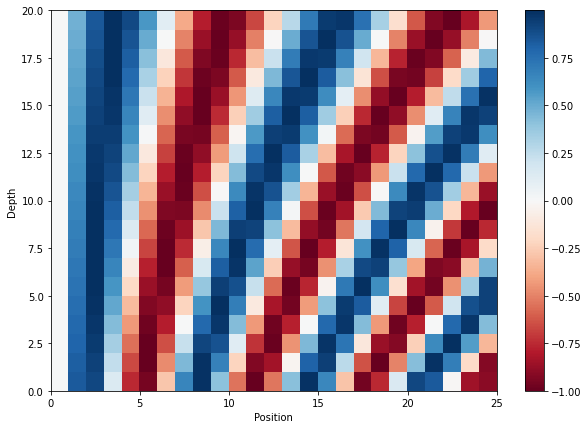

In [ ]:
n, d = 25, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.pcolormesh(pos_encoding[:20,:], cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

## Masking

Two types of masking are required. One is for the tokenized inputs which are padding with zeros. This is the padding mask. The other is to mask other tokens in the sequence that the model is trying to learn. This is the look ahead mask.

In [ ]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # adding dimensions for attention logits compabitility
    return seq[:, tf.newaxis, tf.newaxis, :] #(batch_size, 1, 1, seq_len)

x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [ ]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

In [ ]:
a = tf.ones((3,3))
tf.linalg.band_part(a, 0, 0)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)>

## Embedding
- Learned embeddings convert tokens to vectors of dimension $d_\text{model}$

# Model

## Encoder
- 6 layers
- 2 sub-layers per layer
    - Embedd
    - Position encoding
    - Multi-head self attention
    - FC Feed-forward
    - Residual connections around each sub-layer




In [ ]:
# The encoder and decoder also contain a feed forward section with two dense
# layers and relu activation between
def point_wise_feed_forward_network(d_model, d_ff):
    return tf.keras.Sequential([layers.Dense(d_ff, activation='relu'),
                                layers.Dense(d_model)])


In [ ]:
class EncoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout_rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, d_ff)

        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, x, training, mask):
        attn_out, _ = self.mha(x, x, x, mask) # (batch_size, input_seq_len, d_model)
        attn_out = self.dropout1(attn_out, training=training)
        out1 = self.layernorm1(x + attn_out)

        ff_out = self.ffn(out1)
        ff_out = self.dropout2(ff_out, training=training)
        out2 = self.layernorm2(out1 + ff_out) # (batch_size, input_seq_len, d_model)

        return out2


In [ ]:
tf.random.set_seed(42)
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)


TensorShape([64, 43, 512])

In [ ]:
class Encoder(layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, d_ff, input_vocab_size,
                 maximum_position_encoding, dropout_rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding,
                                                self.d_model)
        
        self.enc_layers = [EncoderLayer(d_model, num_heads, d_ff, dropout_rate)
                            for i in range(num_layers)]
        self.dropout = layers.Dropout(dropout_rate)

    def call(self, x, training, mask):
        
        seq_len = tf.shape(x)[1]
        
        # prep inputs with embedding and pos encoding
        x = self.embedding(x) # (batch_size, input_seq_len, d_model)
        # embedding layer weights are multiplied by sqrt(d_model) sec 3.4
        x *= tf.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        

        x = self.dropout(x, training=training)
        # now go through all the encoding layers
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x # (batch_size, input_seq_len, d_model)



In [ ]:
tf.random.set_seed(42)
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                         d_ff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)
sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)


(64, 62, 512)


## Decoder
- 6 layers
- Same 2 layers as Encoder but with a third layer between
    - Middle layer performs multi-head attention on output from Encoder
    - Same residual connections

In [ ]:
class DecoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout_rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mmha = MultiHeadAttention(d_model, num_heads)
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, d_ff)

        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)
        self.dropout3 = layers.Dropout(dropout_rate)

    def call(self, x, encoder_out, training, look_ahead_mask, padding_mask):
        mask_attn_out, attn_weights_block1 = self.mmha(x, x, x, look_ahead_mask) # (batch_size, target_seq_len, d_model)
        mask_attn_out = self.dropout1(mask_attn_out, training=training)
        out1 = self.layernorm1(mask_attn_out + x)

        attn_out, attn_weights_block2 = self.mha(encoder_out, encoder_out, 
                                                 out1, padding_mask)
        attn_out = self.dropout2(attn_out, training=training)
        out2 = self.layernorm2(attn_out + out1)

        ff_out = self.ffn(out2)
        ff_out = self.dropout3(ff_out, training=training)
        out3 = self.layernorm3(ff_out + out2) # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [ ]:
class Decoder(layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, d_ff, target_vocab_size,
                 maximum_position_encoding, dropout_rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding,
                                                d_model)
        
        self.dec_layers = [DecoderLayer(d_model, num_heads, d_ff, dropout_rate)
                            for i in range(num_layers)]
        self.dropout = layers.Dropout(dropout_rate)

    def call(self, x, enc_output, training,  
             look_ahead_mask, padding_mask):
        
        seq_len = tf.shape(x)[1]
        attn_weights = {}
        
        # prep inputs with embedding and pos encoding
        x = self.embedding(x) # (batch_size, input_seq_len, d_model)
        # embedding layer weights are multiplied by sqrt(d_model) sec 3.4
        x *= tf.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        # now go through all the encoding layers
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, 
                                                   look_ahead_mask,padding_mask)
            attn_weights[f'decoder_layer{i+1}_block1'] = block1
            attn_weights[f'decoder_layer{i+1}_block2'] = block2

        return x, attn_weights # (batch_size, input_seq_len, d_model)

In [ ]:
tf.random.set_seed(42)
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,
                         d_ff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape


(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

# Transformer
Finally construct the full transformer.

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, d_ff, input_vocab_size,
                 target_vocab_size, pe_input, pe_target, dropout_rate=0.1):
        super(Transformer, self).__init__()
    
        self.encoder = Encoder(num_layers, d_model, num_heads, d_ff, 
                            input_vocab_size, pe_input, dropout_rate)
        
        self.decoder = Decoder(num_layers, d_model, num_heads, d_ff, 
                            input_vocab_size, pe_target, dropout_rate)
        
        self.final_layer = layers.Dense(target_vocab_size)

    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask,
             dec_padding_mask):
        # (batch_size, inp_seq_len, d_model)
        enc_output = self.encoder(inp, training, enc_padding_mask)

        dec_output, attention_weights  = self.decoder(tar, enc_output, training, 
                                                look_ahead_mask,dec_padding_mask)
        
        # (batch_size, tar_seq_len, target_vocab_size)
        final_output = self.final_layer(dec_output)

        return final_output, attention_weights




In [ ]:
tf.random.set_seed(42)
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, d_ff=2048,
    input_vocab_size=8500, target_vocab_size=8000,
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False,
                               enc_padding_mask=None,
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)


TensorShape([64, 36, 8000])

# Train



Hyperparameters

In [ ]:
num_layers = 4
d_model = 128
d_ff = 512
num_heads = 8
dropout_rate = 0.1

## Optimizer
- Adam $\beta_1$ = 0.9, $\beta_2$ = 0.98 and $\epsilon$ = $10^{-9}$
- Custom learning rate scheduler
    - increase learning rate linearly for `warm_up_steps` then decrease it proportionally according to the step number.

In [ ]:
# learning rate scheduler, sec 5.3
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps = 4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = tf.cast(d_model, dtype=tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        lr = tf.math.rsqrt(self.d_model) * tf.math.minimum(tf.math.rsqrt(step), 
                                                           step*self.warmup_steps**-1.5)

        return lr
learning_rate = CustomSchedule(d_model)

Text(0.5, 0, 'Train Step')

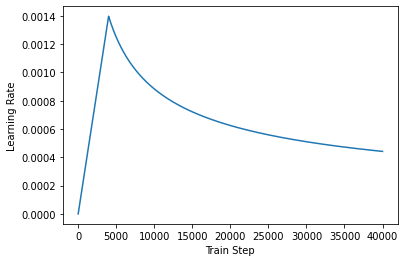

In [ ]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

## Loss
The target sequences are padded so a mask needs to be applied to accurately calculate the loss.


In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

## Training and checkpoints
The targets for each input are the inputs shifted by one. The true output is always passed to the model at the next timestep regardless of what the model predicted at the current timestep. So the model at timestep $t$ is not hindered by the model's performance at $t-1$.

In [ ]:
# examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
#                                as_supervised=True)
# train_examples, val_examples = examples['train'], examples['validation']

# model_name = "ted_hrlr_translate_pt_en_converter"
# tf.keras.utils.get_file(
#     f"{model_name}.zip",
#     f"https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip",
#     cache_dir='.', cache_subdir='', extract=True
# )

# tokenizers = tf.saved_model.load(model_name)

# def tokenize_pairs(pt, en):
#     pt = tokenizers.pt.tokenize(pt)
#     # Convert from ragged to dense, padding with zeros.
#     pt = pt.to_tensor()

#     en = tokenizers.en.tokenize(en)
#     # Convert from ragged to dense, padding with zeros.
#     en = en.to_tensor()
#     return pt, en
# def make_batches(ds):
#   return (
#       ds
#       .cache()
#     #   .shuffle(BUFFER_SIZE)
#       .batch(BATCH_SIZE)
#       .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
#       .prefetch(tf.data.AUTOTUNE))

# train_batches = make_batches(train_examples)
# val_batches = make_batches(val_examples)

# tokenizers.ru = tokenizers.pt


In [ ]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
    for pt in pt_examples.numpy():
        print(pt.decode('utf-8'))

    print()

    for en in en_examples.numpy():
        print(en.decode('utf-8'))

к : успех , перемены возможны только с оружием в руках .
документация и методика практического обучения также доступна и выпущена creative commons .
( видео ) диди пиклз : сейчас четыре часа утра .

c : success , the change is only coming through the barrel of the gun .
the documentation and the hands-on teaching methodology is also open-source and released as the creative commons .
( video ) didi pickles : it 's four o'clock in the morning .


In [ ]:
encoded = tokenizers.en.tokenize(en_examples)

for row in encoded.to_list():
    print(row)

[2, 41, 28, 1103, 14, 84, 243, 93, 200, 389, 218, 84, 6405, 87, 84, 2473, 16, 3]
[2, 84, 3914, 464, 85, 84, 702, 15, 104, 1495, 2346, 2024, 93, 187, 435, 15, 942, 85, 2533, 111, 84, 1068, 5725, 16, 3]
[2, 10, 400, 11, 168, 379, 1026, 1125, 28, 90, 9, 57, 316, 53, 9, 2501, 89, 84, 813, 16, 3]


In [ ]:
round_trip = tokenizers.en.detokenize(encoded)
for line in round_trip.numpy():
    print(line.decode('utf-8'))

c : success , the change is only coming through the barrel of the gun .
the documentation and the hands - on teaching methodology is also open - source and released as the creative commons .
( video ) didi pickles : it ' s four o ' clock in the morning .


In [ ]:
tokens = tokenizers.en.lookup(encoded)
tokens

<tf.RaggedTensor [[b'[START]', b'c', b':', b'success', b',', b'the', b'change', b'is', b'only', b'coming', b'through', b'the', b'barrel', b'of', b'the', b'gun', b'.', b'[END]'], [b'[START]', b'the', b'document', b'##ation', b'and', b'the', b'hands', b'-', b'on', b'teaching', b'method', b'##ology', b'is', b'also', b'open', b'-', b'source', b'and', b'released', b'as', b'the', b'creative', b'commons', b'.', b'[END]'], [b'[START]', b'(', b'video', b')', b'did', b'##i', b'pick', b'##les', b':', b'it', b"'", b's', b'four', b'o', b"'", b'clock', b'in', b'the', b'morning', b'.', b'[END]']]>

In [ ]:
# create the transformer
tf.random.set_seed(42)

transformer = Transformer(num_layers = num_layers, 
                          d_model = d_model,
                          num_heads = num_heads, 
                          d_ff = d_ff,
                          input_vocab_size=tokenizers.ru.get_vocab_size(),
                          target_vocab_size = tokenizers.en.get_vocab_size(),
                          pe_input=1000,
                          pe_target=1000,
                          dropout_rate=dropout_rate)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False,
                               enc_padding_mask=None,
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)


TensorShape([64, 36, 8000])

In [ ]:
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [ ]:
!rm -rf ./checkpoints/

In [ ]:
checkpoint_path = "./checkpoints/train"

# Keyword arguments are set as attributes of this object, 
# and are saved with the checkpoint. Values must be trackable objects.
ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

In [ ]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp,
                                        True,
                                        enc_padding_mask,
                                        combined_mask,
                                        dec_padding_mask)
        # print(inp)
        # print(tar_inp)
        # print(predictions)
        
        loss = loss_function(tar_real, predictions)

        # if batch % 200 ==0:
        #     ru_sent = tokenizers.ru.detokenize(inp)
        #     ru_sent = ru_sent.numpy()[0].decode('utf-8')
        #     print(ru_sent)

        #     en_sent = tokenizers.en.detokenize(tar)
        #     print(en_sent.numpy()[0].decode('utf-8'))

        #     text, _, _ = evaluate(ru_sent, max_length=40)
        #     print(text)
        #     print()

    
    gradients = tape.gradient(loss, transformer.trainable_variables)
    # print(gradients[0])
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

In [ ]:
import time

EPOCHS = 20
step = 0
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    # inp -> russian, tar -> english
    for (batch, (inp, tar)) in enumerate(train_batches):
        train_step(inp, tar)

        if batch % 50 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

    ckpt_save_path = ckpt_manager.save()
    
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')
    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')



так вот , этот подход делает возможным такие вещи как — прочесывание всех доступных данных из самых разных источников для определения ключевых закономерностеи и сведения их воедино . то , что невозможно было сделать раньше .
now this approach makes possible things like combing through all available data from very different sources , identifying key relationships and putting them in one place , something that ' s been nearly impossible to do before .
tf.Tensor(
[[   2 1759 4613 4613 4613 4613 4613 4613 4613 4613 4613 4613 4613 4613
  4613 4613 4613 4613 4613 4613 4613 4613 4613 4613 4613 4613 4613 4613
  4613 4613 4613 4613 4613 4613 4613 4613 4613 4613 4613 4613 4613]], shape=(1, 41), dtype=int64)
tf.Tensor(b'loss perceived perceived perceived perceived perceived perceived perceived perceived perceived perceived perceived perceived perceived perceived perceived perceived perceived perceived perceived perceived perceived perceived perceived perceived perceived perceived perceived percei

tf.Tensor(b"i ' s a world , and i ' s a world , and i ' s a world .", shape=(), dtype=string)

Epoch 1 Batch 1000 Loss 6.4512 Accuracy 0.1250
Epoch 1 Batch 1050 Loss 6.3912 Accuracy 0.1291
Epoch 1 Batch 1100 Loss 6.3349 Accuracy 0.1332
Epoch 1 Batch 1150 Loss 6.2813 Accuracy 0.1371
и он усугубляет положение , сказав : « вообще - то нигде » .
` ` and he makes it worse by saying , ` ` actually , i do n ' t have a place . ' ' ' '
tf.Tensor(
[[ 2 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38
  38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38]], shape=(1, 41), dtype=int64)
tf.Tensor(b'` ` ` ` ` ` ` ` ` ` ` ` ` ` ` ` ` ` ` ` ` ` ` ` ` ` ` ` ` ` ` ` ` ` ` ` ` ` ` `', shape=(), dtype=string)

Epoch 1 Batch 1200 Loss 6.2298 Accuracy 0.1410
Epoch 1 Batch 1250 Loss 6.1840 Accuracy 0.1445
Epoch 1 Batch 1300 Loss 6.1397 Accuracy 0.1477
Epoch 1 Batch 1350 Loss 6.0965 Accuracy 0.1509
с тех пор я решил , что не вправе утешать умирающих при помощи лжи .
from that moment forward

tf.Tensor(b"i ' m a lot of the world , i ' m going to be a lot of the world .", shape=(), dtype=string)

Epoch 1 Batch 1400 Loss 6.0563 Accuracy 0.1539
Epoch 1 Batch 1450 Loss 6.0176 Accuracy 0.1569
Epoch 1 Batch 1500 Loss 5.9833 Accuracy 0.1594
Epoch 1 Batch 1550 Loss 5.9491 Accuracy 0.1620
взгляните на это , это не основано на статистике .
you take a look at this , this is not based on statistics .
tf.Tensor([[  2  95  91   9 117 112 112  39 131 131 131 131  16   3]], shape=(1, 14), dtype=int64)
tf.Tensor(b"so we ' re not not a very very very very .", shape=(), dtype=string)

Epoch 1 Batch 1600 Loss 5.9165 Accuracy 0.1643
Epoch 1 Batch 1650 Loss 5.8846 Accuracy 0.1668
Epoch 1 Batch 1700 Loss 5.8552 Accuracy 0.1689
Epoch 1 Batch 1750 Loss 5.8253 Accuracy 0.1712
археология дает нам возможность изучать древние цивилизации и увидеть в чем они преуспели , а в чем потерпели неудачу .
because archaeology gives us an opportunity to study past civilizations , and see where they succeeded and 

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7fa04eec7830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


KeyboardInterrupt: ignored

# Evaluate

In [ ]:
def evaluate(sentence, max_length=40):
    # inp sentence is russian, hence adding the start and end token
    sentence = tf.convert_to_tensor([sentence])
    sentence = tokenizers.ru.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # as the target is english, the first word to the transformer should be the
    # english start token.
    start, end = tokenizers.en.tokenize([''])[0]
    output = tf.convert_to_tensor([start])
    output = tf.expand_dims(output, 0)

    for i in range(max_length):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input,
                                                    output,
                                                    False,
                                                    enc_padding_mask,
                                                    combined_mask,
                                                    dec_padding_mask)

        # select the last word from the seq_len dimension
        predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.argmax(predictions, axis=-1)

        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

        # return the result if the predicted_id is equal to the end token
        if predicted_id == end:
            break

    # output.shape (1, tokens)
    print(output)
    text = tokenizers.en.detokenize(output)[0]  # shape: ()

    tokens = tokenizers.en.lookup(output)[0]

    return text, tokens, attention_weights

In [ ]:
tokenizers.en.tokenize([''])[0]

In [ ]:
def print_translation(sentence, tokens, ground_truth):
    print(f'{"Input:":15s}: {sentence}')
    print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
    print(f'{"Ground truth":15s}: {ground_truth}')

In [ ]:
sentence = "Автомобиль, припаркованный на углу, черный"
ground_truth = "The car parked at the corner is black."

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

In [ ]:
for (batch, (inp, tar)) in enumerate(train_batches):
    print(inp)
    print(tar)
    break

In [ ]:
round_trip = reloaded_tokenizers.ru.detokenize(inp)
print(round_trip.numpy()[0].decode('utf-8'))

round_trip = reloaded_tokenizers.en.detokenize(tar)
print(round_trip.numpy()[0].decode('utf-8'))